# Beersheba deconvolution over ROIs

### Corrected energy
- **DES** 1.4-1.8 MeV 
- **Low E stuff (x-rays?)** 0-1 MeV
- **Post compton edge** > 2.4 MeV

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'


from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from IC.invisible_cities.cities.components import track_blob_info_creator_extractor
from IC.invisible_cities.io.hits_io        import load_hits
from IC.invisible_cities.io.hits_io        import hits_from_df
from IC.invisible_cities.core              import system_of_units as units
from IC.invisible_cities.types.symbols     import HitEnergy
from IC.invisible_cities.evm.event_model   import HitCollection
from IC.invisible_cities.evm.event_model   import Cluster
from IC.invisible_cities.evm.event_model   import Hit
from IC.invisible_cities.types.ic_types    import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

pd.set_option('display.max_rows', 200)

#import imageio

#import functions as func


In [8]:
def plot_voxels(df, base_vsize = 12):

    xs = df.X
    ys = df.Y
    zs = df.Z
    es = df.E

    the_hits = []
    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)
    
    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)
    
    vsizex = voxels[0].size[0]
    vsizey = voxels[0].size[1]
    vsizez = voxels[0].size[2]

    min_corner_x = min(v.X for v in voxels) - vsizex/2.
    min_corner_y = min(v.Y for v in voxels) - vsizey/2.
    min_corner_z = min(v.Z for v in voxels) - vsizez/2.

    
    x = [np.round(v.X/vsizex) for v in voxels]
    y = [np.round(v.Y/vsizey) for v in voxels]
    z = [np.round(v.Z/vsizez) for v in voxels]
    e = [v.E for v in voxels]

    x_min = int(min(x))
    y_min = int(min(y))
    z_min = int(min(z))

    x_max = int(max(x))
    y_max = int(max(y))
    z_max = int(max(z))

    VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
    #print(VOXELS.shape)

    # sort through the event set the "turn on" the hit voxels
    cmap = cm.viridis
    norm = Normalize(vmin=0, vmax=max(e))

    colors = np.empty(VOXELS.shape, dtype=object)
    for q in range(0,len(z)):
        VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
        colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

    # and plot everything
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    #a,b,c is spacing in mm needs an extra dim
    a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
    a = a*vsizex + min_corner_x
    b = b*vsizey + min_corner_y
    c = c*vsizez + min_corner_z

    # a, b, c are the corners of the voxels
    ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

    ax.set_xlabel('x (mm)')#,fontsize=16)
    ax.set_ylabel('y (mm)')#,fontsize=16)
    ax.set_zlabel('z (mm)')#,fontsize=16)


    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm)
    cb.set_label('Energy (keV)')

    fig.suptitle('voxelised')

    #ax.view_init(-160, 90)

    plt.show(fig)

def plotter(df, evt):
    evt_interest = df[df.event == evt]
    
    print('======================')
    print(f'EVENT {evt}')
    print(f'Total energy {evt_interest.Ec.sum():.2f} MeV')
    print('======================\n')
    hits_cut = coref.timefunc(cut_sensors)(evt_interest.copy())
    hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
    pitch = 15.55
    # then applying transformations to convert to 'SiPM outputs'
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))


    xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
    yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
    zz = hits_cut.Z.unique()

    axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');

    fig.suptitle('Processed Sensors Signal_' + str(evt) + ' - rebin = 4', fontsize=30)
    #plt.savefig(f'plots/hits_{evt}.pdf')
    plt.show(fig)

def plotter_3d(evt_interest, evt):
    # plot
    hits_cut = coref.timefunc(cut_sensors)(evt_interest.copy())
    hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
    
    xt = hits_drop.X
    yt = hits_drop.Y
    zt = hits_drop.Z
    et = hits_drop.E
    
    fig = plt.figure()
    #fig.suptitle('3D post deconvolution ' + str(evt), fontsize=30)
    fig.suptitle(f'Electron candidate event {evt}', fontsize=30)
    ax = fig.add_subplot(111, projection='3d')
    
    
    
    ets = et > 0 # eliminate small things for measurement
    
    #p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
    #plt_sphere([(-track.blob2_x.values[0], -track.blob2_y.values[0], -track.blob2_z.values[0])], [blobR])
    p = ax.scatter([xt[ets]], yt[ets], zt[ets], c=et[ets], alpha=0.65, cmap='viridis', s = 30)#, s = et[ets])
    #q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')
    
    # overlay the blobs and their radii
    
    cb = fig.colorbar(p, ax=ax)
    cb.set_label('Energy (keV)')
    
    
    ax.set_xlabel('\nx (mm)')
    ax.set_ylabel('\ny (mm)')
    ax.set_zlabel('\nz (mm)')
    
    #ax.set_xlim([-300, -100])
    #ax.set_ylim([250, 450])
    #ax.set_zlim([1600, 1800])
    #ax.view_init(20, -150)
    
    #plt.savefig(f'gif_making/deconv/angle_{i}.png')
    #plt.savefig(f'plots/hits_3d_{evt}.pdf')
    plt.show()

    return hits_drop


# beersheba garbage

In [3]:
# set these once and forget
PSF_PATH = '/gluster/data/next/files/TOPOLOGY_John/N100_data/14914/prod_psf/eutropia/merged_psfs/final_psf.psf'
datatype = 'data'
detector_db = '/gluster/data/next/software/IC_311024/IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'
run_number = 15107


In [ ]:
deconv_params = dict(
  q_cut           = 10, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  psf_fname       = PSF_PATH,     
  e_cut           = 0.2, #15 for 6mm  - 15 for 6mm
  n_iterations    = 10, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-9,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint,
  satellite_params = dict(satellite_start_iter = 100,
                          satellite_max_size   = 25,
                          e_cut                = 0.9,
                          cut_type             = CutType.rel),
  energy_type     = HitEnergy.Ec,
  cut_type        = CutType.rel)
 # inter_method    = InterpolationMethod.cubic)
#satellite_params = dict(satellite_start_iter = 75,
#                        satellite_max_size   = 3,
#                        e_cut                = 0.2,
#                        cut_type             = CutType.rel)
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.

cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])


# First, photopeak

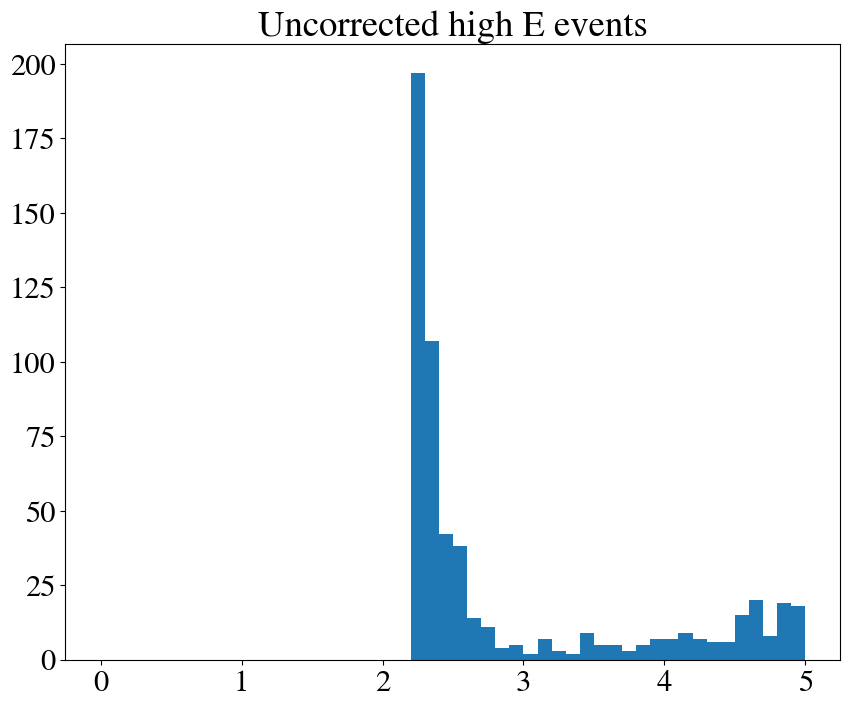

In [40]:
soph_file = 'files/15107_energy_split/corr_post_CE.h5'
post_CE = pd.read_hdf(soph_file, key = 'RECO/Events')

plt.hist(post_CE.groupby('event').Ec.sum(), bins = 50, range = [0, 5])
plt.title('Uncorrected high E events')
plt.show()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3348115,654754,1.742944e+09,0,52.969134,-93.402153,1,-451.525,-93.675,0.0,0.0,569.117375,5.034449,22.698537,-1.0,0.000144,-1,-1.0
3348116,654754,1.742944e+09,0,52.969134,-93.402153,1,-451.525,-32.475,0.0,0.0,569.117375,5.555621,25.048314,-1.0,0.000157,-1,-1.0
3348117,654754,1.742944e+09,0,52.969134,-93.402153,1,-65.775,-278.775,0.0,0.0,569.117375,6.461748,29.133719,-1.0,0.000148,-1,-1.0
3348118,654754,1.742944e+09,0,52.969134,-93.402153,1,351.075,-185.975,0.0,0.0,569.117375,5.291257,23.856392,-1.0,0.000130,-1,-1.0
3348119,654754,1.742944e+09,0,52.969134,-93.402153,1,-34.675,-202.025,0.0,0.0,572.565625,5.184258,101.972949,-1.0,0.000497,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351243,654754,1.742944e+09,0,52.969134,-93.402153,1,335.525,415.475,0.0,0.0,759.797500,6.233183,8.771492,-1.0,NaN,-1,-1.0
3351244,654754,1.742944e+09,0,52.969134,-93.402153,1,-281.475,-62.575,0.0,0.0,763.822125,5.054821,15.384213,-1.0,0.000077,-1,-1.0
3351245,654754,1.742944e+09,0,52.969134,-93.402153,1,-297.025,29.725,0.0,0.0,763.822125,5.051856,15.375189,-1.0,0.000077,-1,-1.0
3351246,654754,1.742944e+09,0,52.969134,-93.402153,1,-50.225,230.375,0.0,0.0,767.494500,5.031432,-2.117011,-1.0,-0.000010,-1,-1.0


EVENT 654754
Total energy 2.40 MeV

Time spent in cut_over_Q: 0.026200294494628906 s
Time spent in drop_isolated: 0.0841374397277832 s


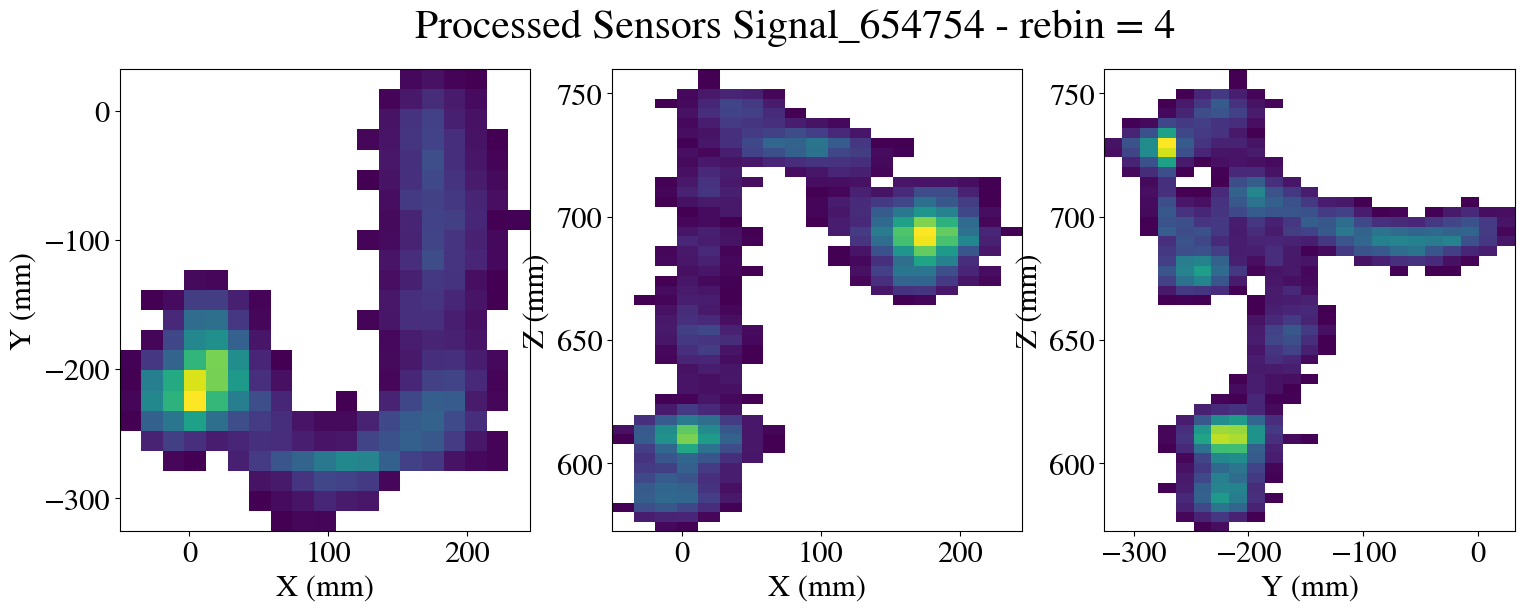

In [62]:
# select event that we know is decent
evt = 654754
evt_interest = post_CE[post_CE.event == evt]
display(evt_interest)
plotter(post_CE, evt)

Time spent in cut_over_Q: 0.020591259002685547 s
Time spent in drop_isolated: 0.06435799598693848 s


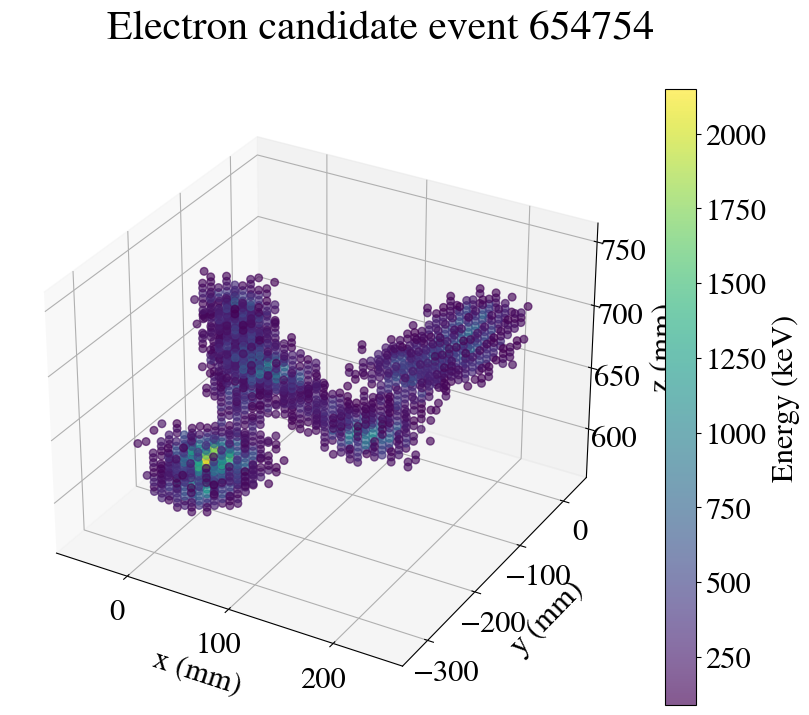

In [63]:
# plot
hits_cut = coref.timefunc(cut_sensors)(evt_interest.copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

xt = hits_drop.X
yt = hits_drop.Y
zt = hits_drop.Z
et = hits_drop.E

fig = plt.figure()
#fig.suptitle('3D post deconvolution ' + str(evt), fontsize=30)
fig.suptitle(f'Electron candidate event {evt}', fontsize=30)
ax = fig.add_subplot(111, projection='3d')



ets = et > 0 # eliminate small things for measurement

#p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
#plt_sphere([(-track.blob2_x.values[0], -track.blob2_y.values[0], -track.blob2_z.values[0])], [blobR])
p = ax.scatter([xt[ets]], yt[ets], zt[ets], c=et[ets], alpha=0.65, cmap='viridis', s = 30)#, s = et[ets])
#q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')

# overlay the blobs and their radii

cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')


ax.set_xlabel('\nx (mm)')
ax.set_ylabel('\ny (mm)')
ax.set_zlabel('\nz (mm)')

#ax.set_xlim([-300, -100])
#ax.set_ylim([250, 450])
#ax.set_zlim([1600, 1800])
#ax.view_init(20, -150)

#plt.savefig(f'gif_making/deconv/angle_{i}.png')
#plt.savefig(f'plots/hits_3d_{evt}.pdf')
plt.show()


# deconvolve

In [64]:
#for iterN in np.arange(10, deconv_params_['n_iterations'], 10):
#    deconv_params_['n_iterations'] = iterN
#    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
#    print(f'{iterN} iterations')
#    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

#for iterN in np.arange(10, deconv_params_['n_iterations'], 10):
#deconv_params_['n_iterations'] = iterN
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
print(f'{iterN} iterations')
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())


20 iterations
Time spent in apply_deconvolution: 80.0977532863617 s


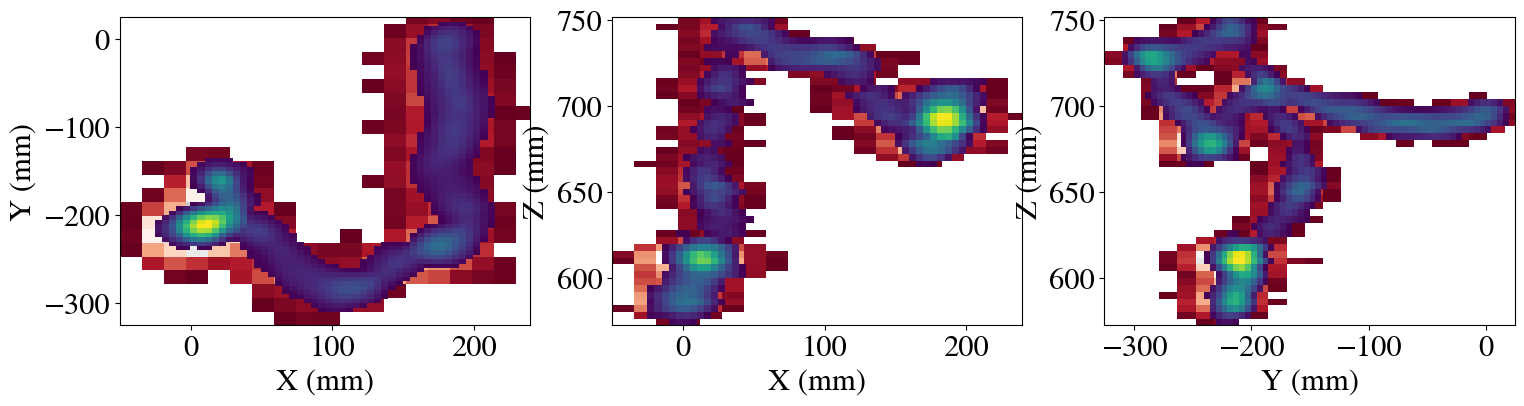

In [67]:
pitch = 15.55
plot_OG = True

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

if plot_OG:
    hits = hits_drop
    # then applying transformations to convert to 'SiPM outputs'
    
    xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
    yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
    zz = hits.Z.unique()
    
    axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001, cmap = 'RdGy');
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');
    
    axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001, cmap = 'RdGy');
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');
    
    
    axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001, cmap = 'RdGy');
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    #fig.suptitle('Sensors Signal', fontsize=30)


xx = np.arange(hits.X.min(), hits.X.max(), 5)
yy = np.arange(hits.Y.min(), hits.Y.max(), 5)

zz = hits.Z.unique()
    
axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

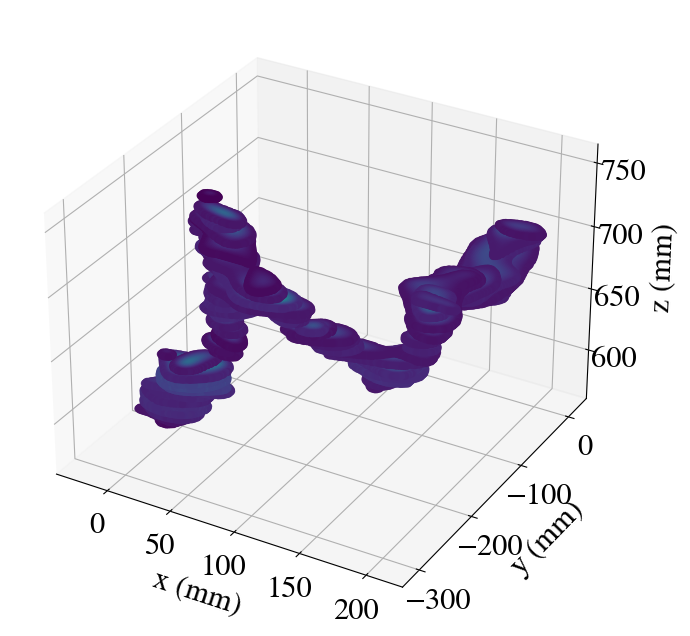

In [47]:
from matplotlib import colors
x = hits_deco.X

y = hits_deco.Y
z = hits_deco.Z
e = hits_deco.E#*1000


em = e > 0 # eliminate small things for measurement


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# annihilate deposits under y = 1650
xq = x[em]
yq = y[em]
zq = z[em]
eq = e[em]

ym = z > 0

#p = ax.scatter(xq[ym], yq[ym], zq[ym], c=eq[ym], alpha=0.08, cmap='viridis')
p = ax.scatter(xq[ym], yq[ym], zq[ym], c=eq[ym], alpha=0.8, cmap='viridis')
#p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
#cb = fig.colorbar(p, ax=ax)
#cb.set_label('Energy (keV)')


ax.set_xlabel('\nx (mm)')
ax.set_ylabel('\ny (mm)')
ax.set_zlabel('\nz (mm)')

#ax.view_init(20, 50)

plt.show()

/tmp/ipykernel_2487487/317636650.py:53: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


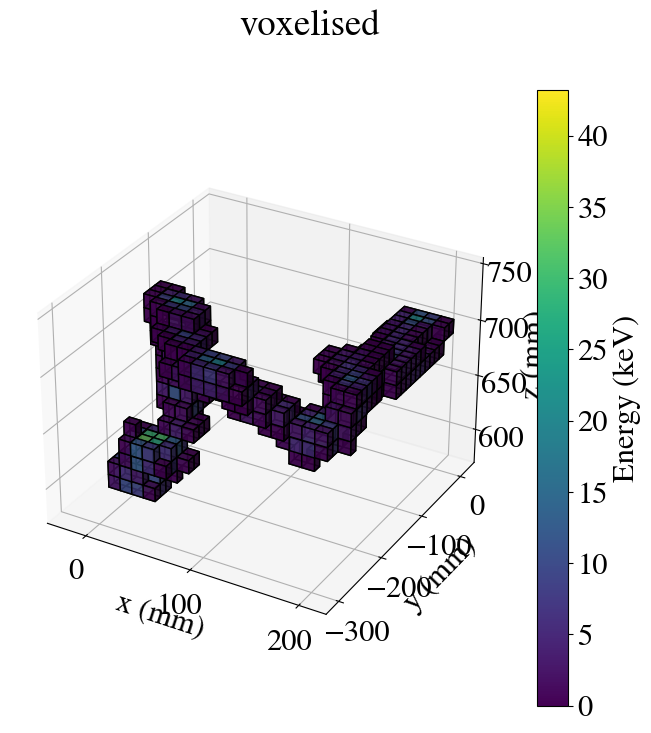

In [22]:
plot_voxels(hits_deco)

/tmp/ipykernel_2487487/317636650.py:53: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


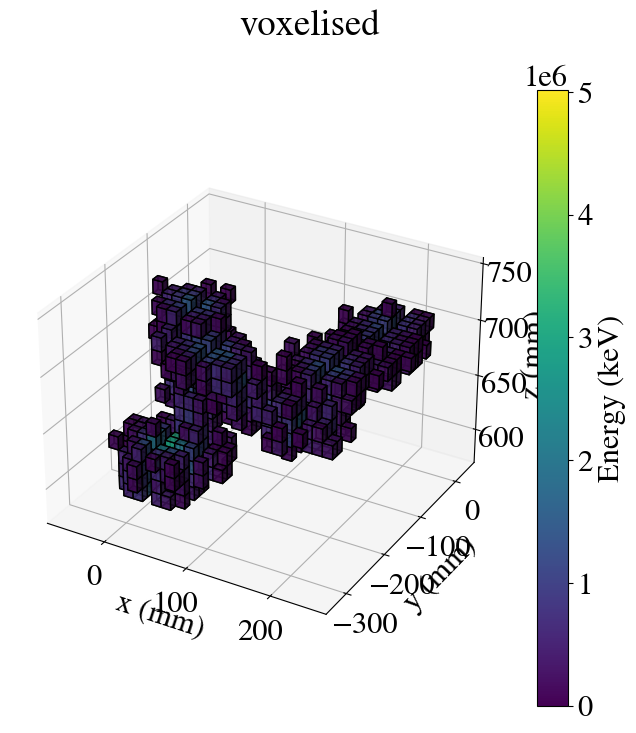

In [23]:
plot_voxels(hits)

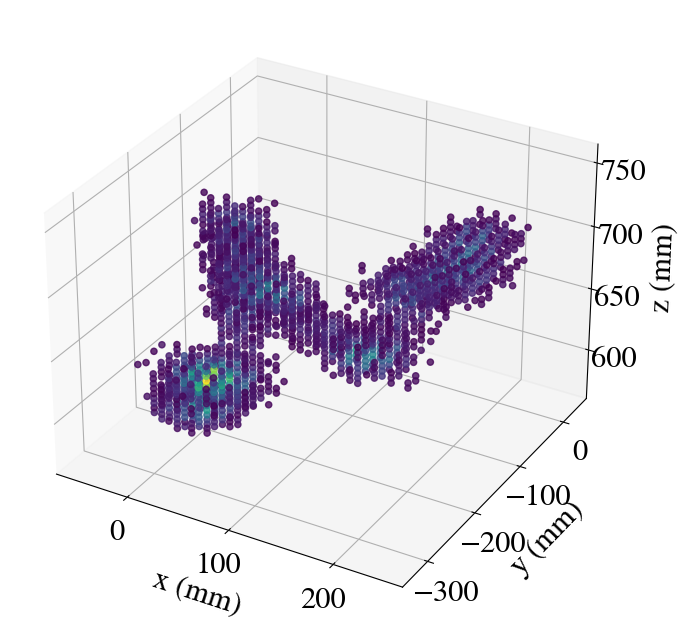

In [24]:
from matplotlib import colors
x = hits.X

y = hits.Y
z = hits.Z
e = hits.E#*1000


em = e > 0 # eliminate small things for measurement


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# annihilate deposits under y = 1650
xq = x[em]
yq = y[em]
zq = z[em]
eq = e[em]

ym = z > 0

#p = ax.scatter(xq[ym], yq[ym], zq[ym], c=eq[ym], alpha=0.08, cmap='viridis')
p = ax.scatter(xq[ym], yq[ym], zq[ym], c=eq[ym], alpha=0.8, cmap='viridis')
#p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
#cb = fig.colorbar(p, ax=ax)
#cb.set_label('Energy (keV)')


ax.set_xlabel('\nx (mm)')
ax.set_ylabel('\ny (mm)')
ax.set_zlabel('\nz (mm)')

#ax.view_init(20, 50)

plt.show()

# DES

In [32]:
deconv_params = dict(
  q_cut           = 10, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  psf_fname       = PSF_PATH,     
  e_cut           = 0.05, #15 for 6mm  - 15 for 6mm
  n_iterations    = 30, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-9,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint,
  satellite_params = dict(satellite_start_iter = 100,
                          satellite_max_size   = 25,
                          e_cut                = 0.9,
                          cut_type             = CutType.rel),
  energy_type     = HitEnergy.Ec,
  cut_type        = CutType.rel)
 # inter_method    = InterpolationMethod.cubic)
#satellite_params = dict(satellite_start_iter = 75,
#                        satellite_max_size   = 3,
#                        e_cut                = 0.2,
#                        cut_type             = CutType.rel)
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.

cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])


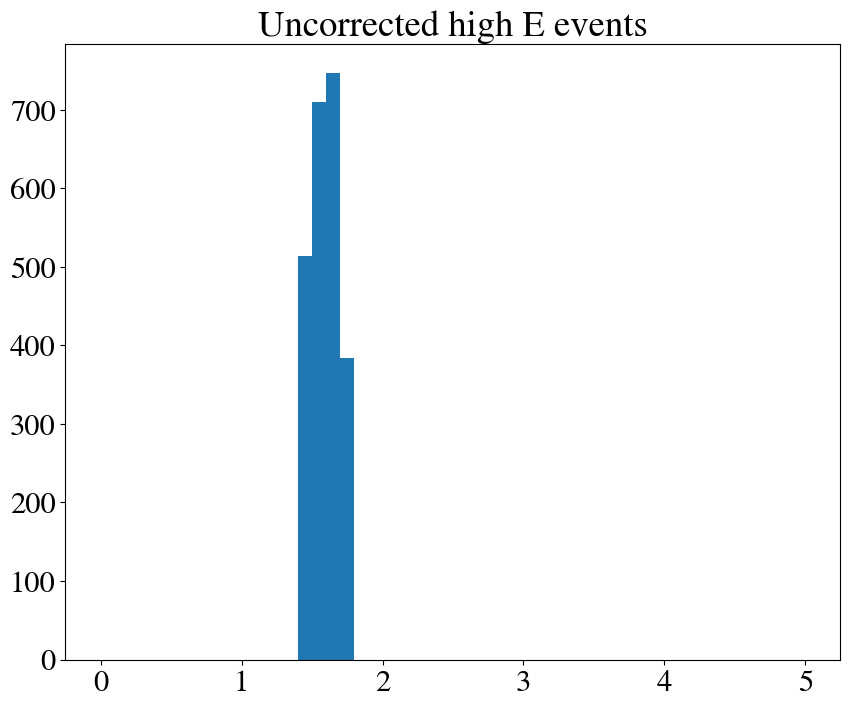

In [33]:
soph_file = 'files/15107_energy_split/corr_DES.h5'
post_DES = pd.read_hdf(soph_file, key = 'RECO/Events')

plt.hist(post_DES.groupby('event').Ec.sum(), bins = 50, range = [0, 5])
plt.title('Uncorrected high E events')
plt.show()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
1799424,1099492,1.742949e+09,1,-23.317714,-52.27715,1,-420.425,-294.825,0.0,0.0,145.911797,5.407240,-1.875081,-1.0,NaN,-1,-1.0
1799425,1099492,1.742949e+09,1,-23.317714,-52.27715,1,-112.425,-109.725,0.0,0.0,145.911797,5.938572,-2.059333,-1.0,-0.000010,-1,-1.0
1799426,1099492,1.742949e+09,1,-23.317714,-52.27715,1,57.625,-0.875,0.0,0.0,145.911797,6.051246,-2.098405,-1.0,-0.000010,-1,-1.0
1799427,1099492,1.742949e+09,1,-23.317714,-52.27715,1,490.025,168.675,0.0,0.0,145.911797,6.723481,-2.331518,-1.0,NaN,-1,-1.0
1799428,1099492,1.742949e+09,1,-23.317714,-52.27715,1,-312.575,368.825,0.0,0.0,148.812250,5.077242,-1.422090,-1.0,NaN,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1802255,1099492,1.742949e+09,2,-59.075553,-39.89420,1,88.725,-139.825,0.0,0.0,1374.037125,5.192138,45.044484,-1.0,0.000219,-1,-1.0
1802256,1099492,1.742949e+09,2,-59.075553,-39.89420,1,119.825,291.575,0.0,0.0,1374.037125,5.218662,45.274590,-1.0,0.000234,-1,-1.0
1802257,1099492,1.742949e+09,2,-59.075553,-39.89420,1,88.725,446.075,0.0,0.0,1374.037125,6.297884,54.637401,-1.0,0.000346,-1,-1.0
1802258,1099492,1.742949e+09,2,-59.075553,-39.89420,1,212.125,-0.875,0.0,0.0,1374.037125,5.138412,44.578386,-1.0,0.000224,-1,-1.0


EVENT 1099492
Total energy 1.74 MeV

Time spent in cut_over_Q: 0.019723892211914062 s
Time spent in drop_isolated: 0.039732933044433594 s


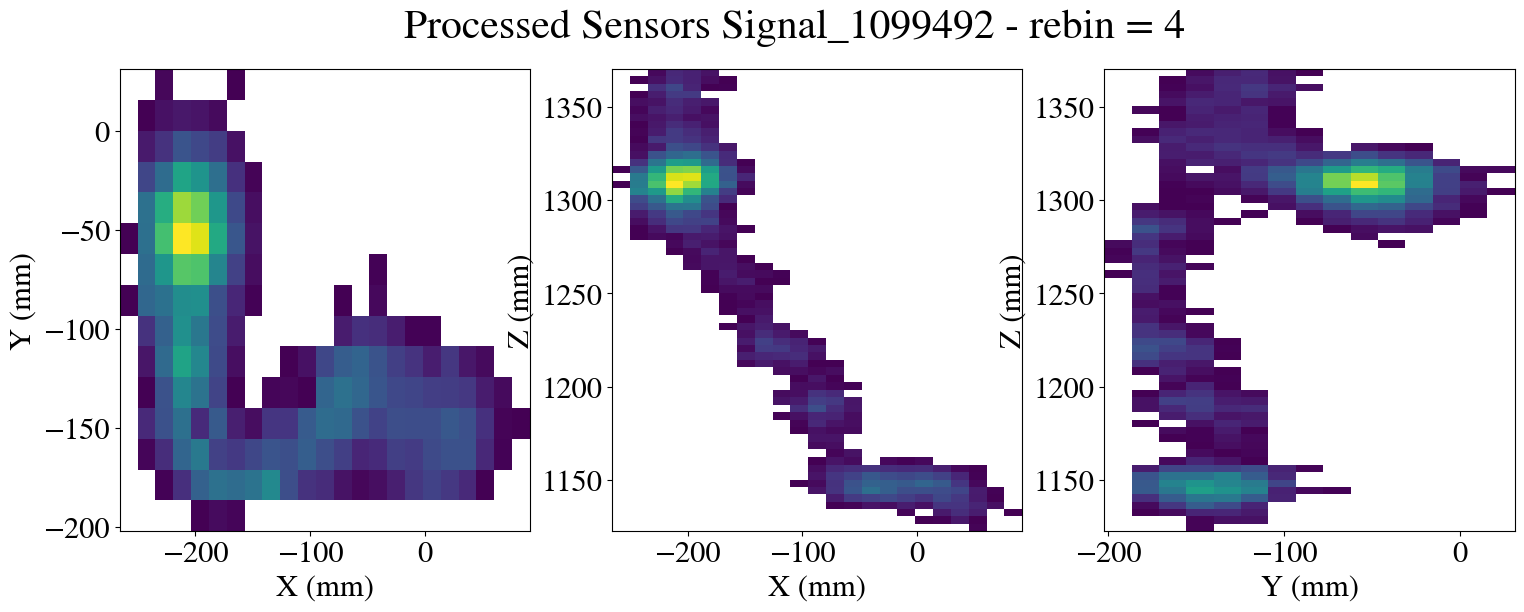

In [34]:
evt = 1099492
evt_interest = post_DES[post_DES.event == evt]
display(evt_interest)
plotter(post_DES, evt)

Time spent in cut_over_Q: 0.01930069923400879 s
Time spent in drop_isolated: 0.03585171699523926 s


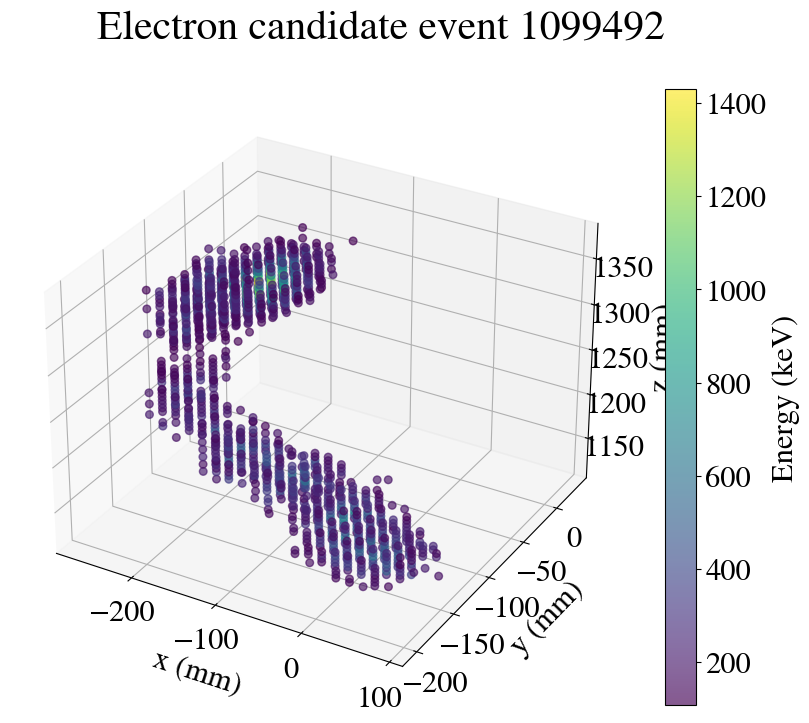

In [35]:
# plot
hits_cut = coref.timefunc(cut_sensors)(evt_interest.copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

xt = hits_drop.X
yt = hits_drop.Y
zt = hits_drop.Z
et = hits_drop.E

fig = plt.figure()
#fig.suptitle('3D post deconvolution ' + str(evt), fontsize=30)
fig.suptitle(f'Electron candidate event {evt}', fontsize=30)
ax = fig.add_subplot(111, projection='3d')



ets = et > 0 # eliminate small things for measurement

#p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
#plt_sphere([(-track.blob2_x.values[0], -track.blob2_y.values[0], -track.blob2_z.values[0])], [blobR])
p = ax.scatter([xt[ets]], yt[ets], zt[ets], c=et[ets], alpha=0.65, cmap='viridis', s = 30)#, s = et[ets])
#q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')

# overlay the blobs and their radii

cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')


ax.set_xlabel('\nx (mm)')
ax.set_ylabel('\ny (mm)')
ax.set_zlabel('\nz (mm)')

#ax.set_xlim([-300, -100])
#ax.set_ylim([250, 450])
#ax.set_zlim([1600, 1800])
#ax.view_init(20, -150)

#plt.savefig(f'gif_making/deconv/angle_{i}.png')
#plt.savefig(f'plots/hits_3d_{evt}.pdf')
plt.show()


In [36]:
#for iterN in np.arange(10, deconv_params_['n_iterations'], 10):
N = deconv_params_['n_iterations']
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
print(f'{N} iterations')
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())


30 iterations
Time spent in apply_deconvolution: 250.7864100933075 s


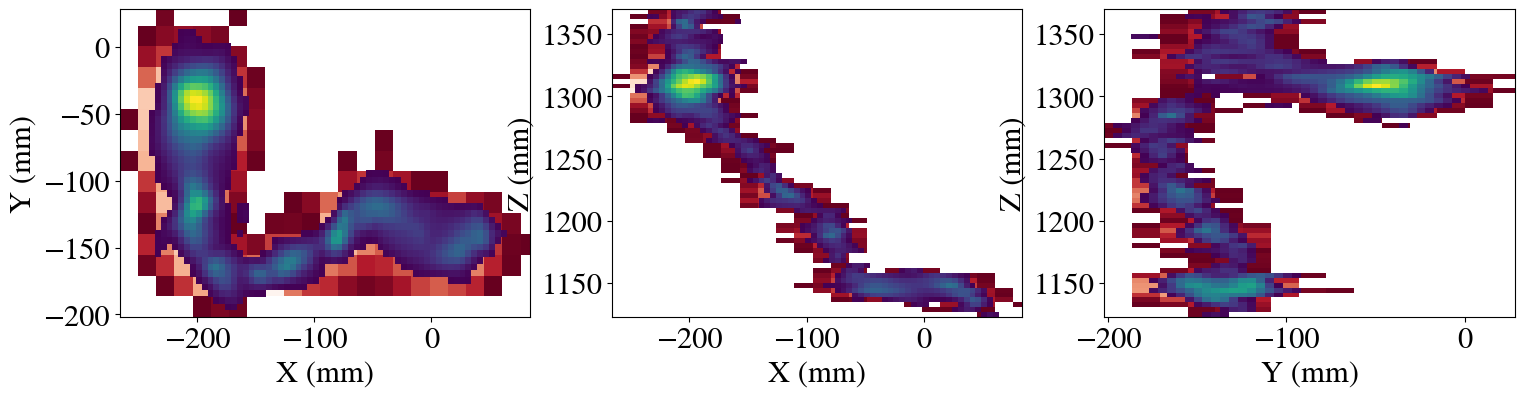

In [37]:
pitch = 15.55
plot_OG = True

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

if plot_OG:
    hits = hits_drop
    # then applying transformations to convert to 'SiPM outputs'
    
    xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
    yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
    zz = hits.Z.unique()
    
    axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001, cmap = 'RdGy');
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');
    
    axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001, cmap = 'RdGy');
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');
    
    
    axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001, cmap = 'RdGy');
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    #fig.suptitle('Sensors Signal', fontsize=30)


xx = np.arange(hits.X.min(), hits.X.max(), 5)
yy = np.arange(hits.Y.min(), hits.Y.max(), 5)

zz = hits.Z.unique()
    
axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

# Low E

In [4]:

deconv_params = dict(
  q_cut           = 10, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  psf_fname       = PSF_PATH,     
  e_cut           = 0.2, #15 for 6mm  - 15 for 6mm
  n_iterations    = 30, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-9,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint,
  satellite_params = dict(satellite_start_iter = 100,
                          satellite_max_size   = 25,
                          e_cut                = 0.9,
                          cut_type             = CutType.rel),
  energy_type     = HitEnergy.Ec,
  cut_type        = CutType.rel)
 # inter_method    = InterpolationMethod.cubic)
#satellite_params = dict(satellite_start_iter = 75,
#                        satellite_max_size   = 3,
#                        e_cut                = 0.2,
#                        cut_type             = CutType.rel)
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.

cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])


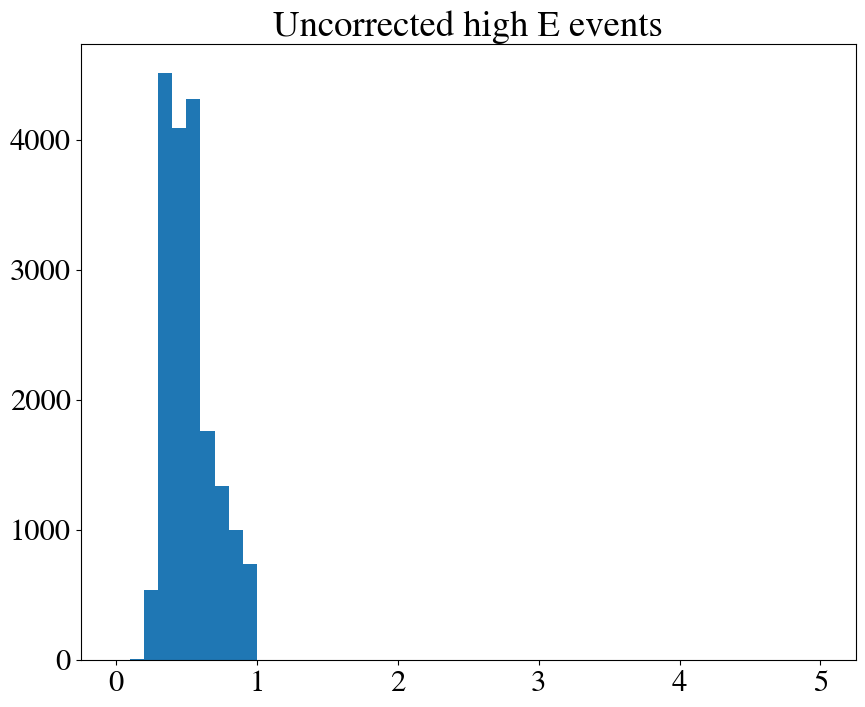

In [ ]:
soph_file = 'files/15107_energy_split/corr_low_E.h5'
low_E = pd.read_hdf(soph_file, key = 'RECO/Events')



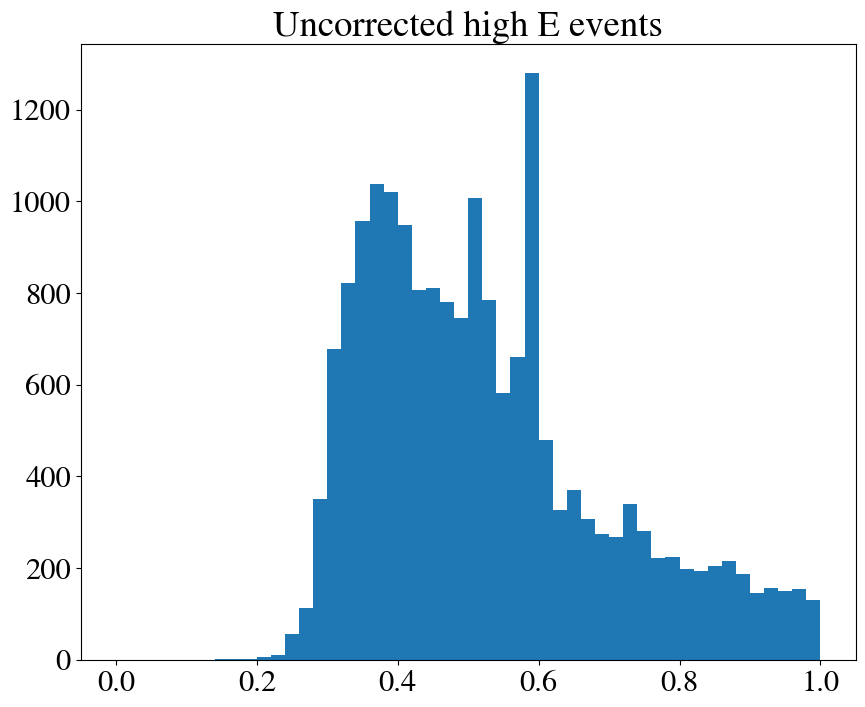

In [6]:
plt.hist(low_E.groupby('event').Ec.sum(), bins = 50, range = [0, 1])
plt.title('Uncorrected high E events')
plt.show()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
18103,1198290,1.742951e+09,0,125.760195,139.807329,1,243.225,91.425,0.0,0.0,362.171625,5.993732,64.701512,-1.0,0.000327,-1,-1.0
18104,1198290,1.742951e+09,0,125.760195,139.807329,1,273.325,307.625,0.0,0.0,362.171625,9.248623,99.837604,-1.0,0.000573,-1,-1.0
18105,1198290,1.742951e+09,0,125.760195,139.807329,1,-482.625,229.875,0.0,0.0,365.569250,5.182848,60.227306,-1.0,NaN,-1,-1.0
18106,1198290,1.742951e+09,0,125.760195,139.807329,1,88.725,-386.625,0.0,0.0,365.569250,6.119411,71.110634,-1.0,0.000382,-1,-1.0
18107,1198290,1.742951e+09,0,125.760195,139.807329,1,73.175,-47.525,0.0,0.0,365.569250,5.808118,67.493252,-1.0,0.000326,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19179,1198290,1.742951e+09,0,125.760195,139.807329,1,-112.425,-109.725,0.0,0.0,508.463500,6.493578,53.306890,-1.0,0.000267,-1,-1.0
19180,1198290,1.742951e+09,0,125.760195,139.807329,1,227.675,260.475,0.0,0.0,508.463500,6.540303,53.690461,-1.0,0.000283,-1,-1.0
19181,1198290,1.742951e+09,0,125.760195,139.807329,1,351.075,-48.025,0.0,0.0,508.463500,8.236981,67.618781,-1.0,0.000356,-1,-1.0
19182,1198290,1.742951e+09,0,125.760195,139.807329,1,257.775,260.975,0.0,0.0,508.463500,5.069935,41.619961,-1.0,0.000224,-1,-1.0


EVENT 1198290
Total energy 0.86 MeV

Time spent in cut_over_Q: 0.03116917610168457 s
Time spent in drop_isolated: 0.02914881706237793 s


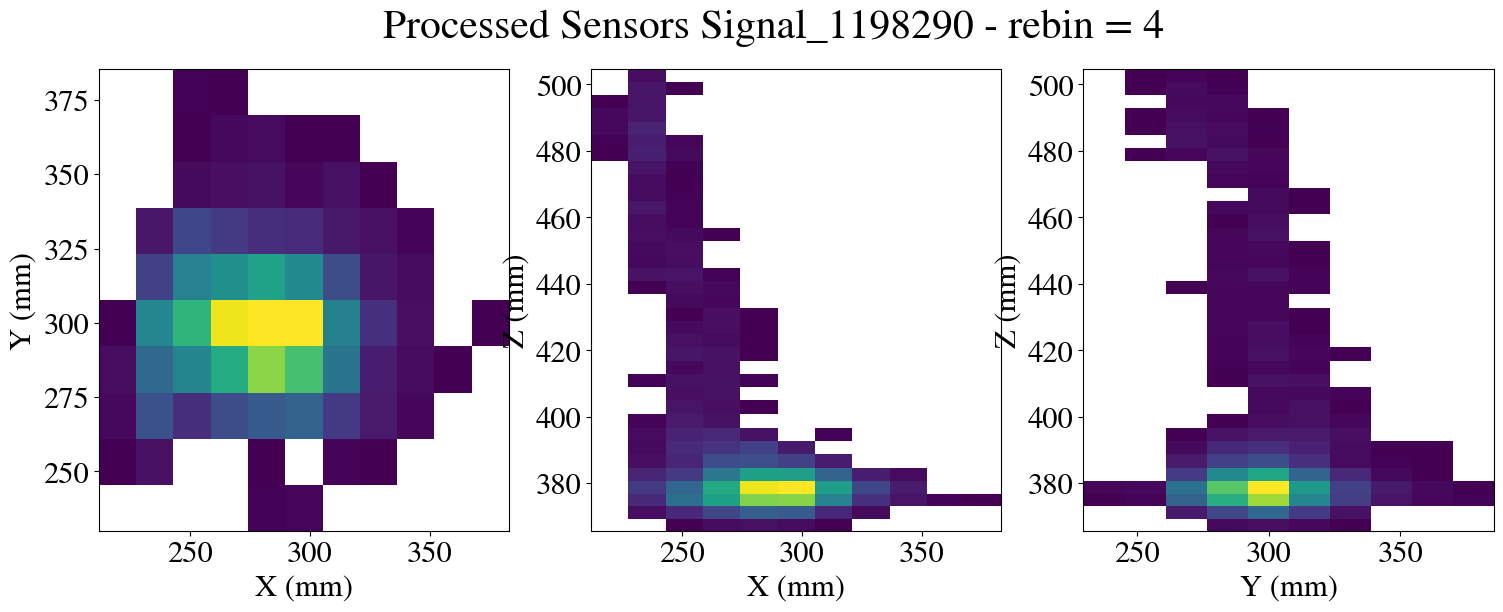

In [7]:
evt = 1198290
evt_interest = low_E[low_E.event == evt]
display(evt_interest)
plotter(low_E, evt)

Time spent in cut_over_Q: 0.03422355651855469 s
Time spent in drop_isolated: 0.03147077560424805 s


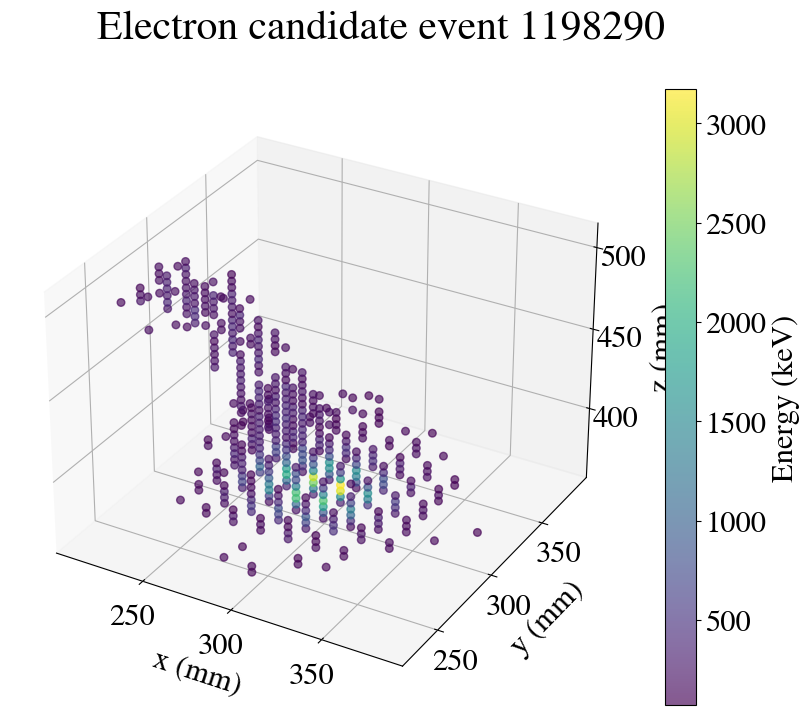

In [9]:
hits_drop = plotter_3d(evt_interest, evt)

In [10]:
display(hits_drop)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1198290,1.742951e+09,0,125.760195,139.807329,1,273.325,292.075,0.0,0.0,365.569250,10.829456,161.272486,-1.0,0.000874,-1,-1.0
1,1198290,1.742951e+09,0,125.760195,139.807329,1,273.325,307.625,0.0,0.0,365.569250,22.208477,330.729096,-1.0,0.001851,-1,-1.0
2,1198290,1.742951e+09,0,125.760195,139.807329,1,288.875,292.075,0.0,0.0,365.569250,13.033806,194.099704,-1.0,0.001064,-1,-1.0
3,1198290,1.742951e+09,0,125.760195,139.807329,1,288.875,307.625,0.0,0.0,365.569250,22.446423,334.272586,-1.0,0.001899,-1,-1.0
4,1198290,1.742951e+09,0,125.760195,139.807329,1,304.425,292.075,0.0,0.0,365.569250,13.297400,198.025161,-1.0,0.001086,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,1198290,1.742951e+09,0,125.760195,139.807329,1,257.775,276.525,0.0,0.0,496.764125,11.616210,155.265488,-1.0,0.000816,-1,-1.0
436,1198290,1.742951e+09,0,125.760195,139.807329,1,227.675,276.025,0.0,0.0,500.667250,15.644673,250.028100,-1.0,0.001273,-1,-1.0
437,1198290,1.742951e+09,0,125.760195,139.807329,1,227.675,291.575,0.0,0.0,500.667250,10.579718,169.081619,-1.0,0.000860,-1,-1.0
438,1198290,1.742951e+09,0,125.760195,139.807329,1,243.225,276.025,0.0,0.0,500.667250,10.138279,162.026689,-1.0,0.000848,-1,-1.0


In [11]:
N = deconv_params_['n_iterations']
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
print(f'{N} iterations')
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())


30 iterations
Time spent in apply_deconvolution: 131.5659213066101 s


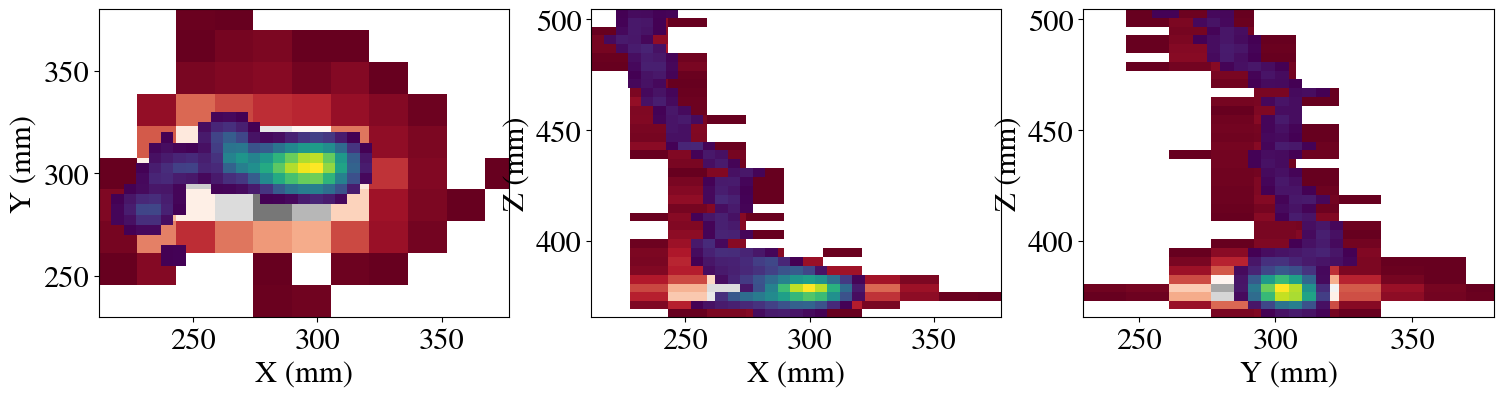

In [13]:
pitch = 15.55
plot_OG = True

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

if plot_OG:
    hits = hits_drop
    # then applying transformations to convert to 'SiPM outputs'
    
    xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
    yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
    zz = hits.Z.unique()
    
    axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001, cmap = 'RdGy');
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');
    
    axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001, cmap = 'RdGy');
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');
    
    
    axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001, cmap = 'RdGy');
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    #fig.suptitle('Sensors Signal', fontsize=30)


xx = np.arange(hits.X.min(), hits.X.max(), 5)
yy = np.arange(hits.Y.min(), hits.Y.max(), 5)

zz = hits.Z.unique()
    
axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');